In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1247 non-null   datetime64[ns]
 1   Close   1247 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


## Preprocessing

In [3]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1247, 1)

In [4]:
SEQ_LEN = 100
WINDOW_SIZE = SEQ_LEN - 1

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)

In [5]:
# Genetic Algorithm
def genetic_algorithm(population_size, generations):
    population = np.random.randint(1, high=25, size=(population_size, 3))
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
        best_chromosome = population[np.argmax(fitness_scores)]
        best_fitness = np.max(fitness_scores)
        
        new_population = []
        
        while len(new_population) < population_size:
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent1, parent2)
            mutate(offspring_1)
            mutate(offspring_2)
            new_population.append(offspring_1)
            new_population.append(offspring_2)
        
        population = np.array(new_population)
    
    return best_chromosome, best_fitness

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    offspring_1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring_2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome, mutation_rate=0.01):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(len(chromosome))
            chromosome[i], chromosome[j] = chromosome[j], chromosome[i]

# Define the fitness function to be optimized
def fitness_function(chromosome):
    lstm_units1 = chromosome[0] * 10
    lstm_units2 = chromosome[1] * 10
    lstm_units3 = chromosome[2] * 10
    
    lstm_units1 = np.abs(lstm_units1) or 128
    lstm_units2 = np.abs(lstm_units2) or 64
    lstm_units3 = np.abs(lstm_units3) or 32

    # Build the LSTM model
    model = Sequential([
        LSTM(lstm_units1, input_shape=(WINDOW_SIZE, X_train.shape[-1]), return_sequences=True),
        LSTM(lstm_units2, return_sequences=True),
        LSTM(lstm_units3, return_sequences=False),
        Dense(1),
    ])

    # Compile and train the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=32,
              verbose=0,
              validation_split=0.1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)

    # Return the negative value of the loss as the fitness score
    return -loss

In [6]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [7]:
# Example usage
population_size = 30
generations = 20

time = timer(None)
best_chromosome, best_fitness = genetic_algorithm(population_size, generations)
time = timer(time)

Generation - 1
4/4 [==============================] - 0s 9ms/step - loss: 0.0026
Generation - 2
4/4 [==============================] - 0s 10ms/step - loss: 8.5805e-04
Generation - 3
4/4 [==============================] - 0s 8ms/step - loss: 0.0030
Generation - 4
4/4 [==============================] - 0s 10ms/step - loss: 8.3697e-04
Generation - 5
4/4 [==============================] - 0s 9ms/step - loss: 0.0011
Generation - 6
4/4 [==============================] - 0s 12ms/step - loss: 8.4300e-04
Generation - 7
4/4 [==============================] - 0s 14ms/step - loss: 0.0018
Generation - 8
4/4 [==============================] - 0s 10ms/step - loss: 0.0012
Generation - 9
4/4 [==============================] - 0s 9ms/step - loss: 0.0012
Generation - 10
4/4 [==============================] - 0s 9ms/step - loss: 0.0022
Generation - 11
4/4 [==============================] - 0s 14ms/step - loss: 0.0031
Generation - 12
4/4 [==============================] - 0s 11ms/step - loss: 0.0019
Genera

In [8]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [14 24 24]
Best Fitness: -0.0007321598241105676
Time Taken: 2 hours 9 minutes and 57.58 seconds.


## Model Evaluation

In [9]:
model = Sequential([
    LSTM(best_chromosome[0] * 10, input_shape=(WINDOW_SIZE, X_train.shape[-1]), return_sequences=True),
    LSTM(best_chromosome[1] * 10, return_sequences=True),
    LSTM(best_chromosome[2] * 10, return_sequences=False),
    Dense(1),
])

model.compile(loss='mean_squared_error',
              metrics=['mae'],
              optimizer='adam')

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/50
29/29 [==============================] - 6s 59ms/step - loss: 0.0113 - mae: 0.0695 - val_loss: 0.0038 - val_mae: 0.0566
Epoch 2/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 0.0018 - val_mae: 0.0363
Epoch 3/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0019 - val_mae: 0.0381
Epoch 4/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0019 - mae: 0.0327 - val_loss: 0.0053 - val_mae: 0.0659
Epoch 5/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0033 - val_mae: 0.0504
Epoch 6/50
29/29 [==============================] - 1s 20ms/step - loss: 0.0018 - mae: 0.0314 - val_loss: 0.0021 - val_mae: 0.0392
Epoch 7/50
29/29 [==============================] - 1s 21ms/step - loss: 0.0014 - mae: 0.0270 - val_loss: 0.0019 - val_mae: 0.0365
Epoch 8/50
29/29 [==============================] - 1s 23ms/step - loss: 0.0013 - m

In [10]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 10ms/step - loss: 6.5303e-04 - mae: 0.0221


[0.0006530277896672487, 0.02206520549952984]

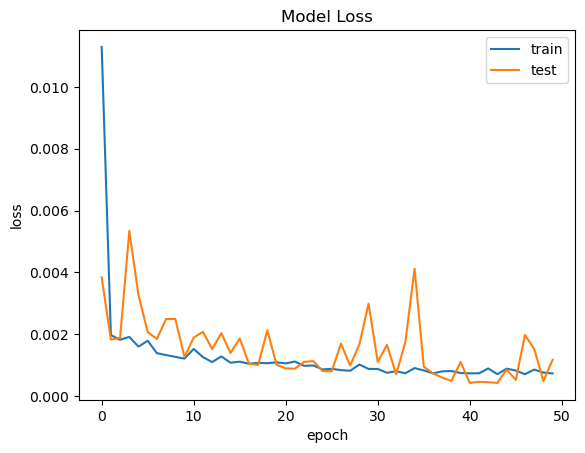

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

4/4 [==============================] - 1s 9ms/step


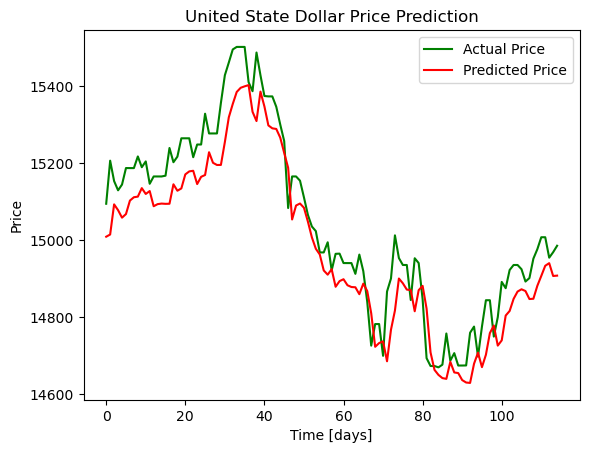

In [12]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [13]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)

matrices(y_test_inverse, y_hat_inverse)

Mean Squared Error for prediction : 7588.846573082995
Mean Absolute Error for prediction : 75.2194055706523
Root Mean Squared Error for prediction : 87.11398609341094
